In [1]:
import numpy as np 
import skimage.io
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from functions import *
from skimage.draw import polygon2mask
from skimage import color

0.0 1.0


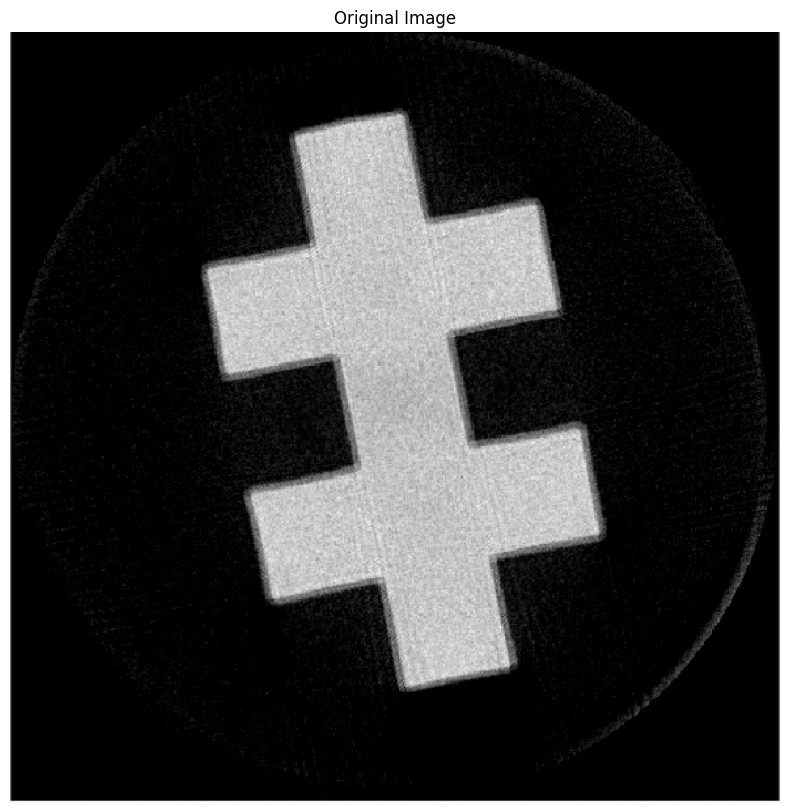

In [2]:
path = '../Chapter06/Data/'
D = skimage.io.imread(path + 'plusplus.png').astype(float) / 255 
D = color.rgb2gray(D)

print(D.min(), D.max())

visualize_the_image(D, 'Original Image')

def visualize_snake_on_image(image, snake, title=None):
    """
    Visualize a snake on an image.
    
    Parameters:
    -----------
    image : ndarray
        Image to visualize
    snake : ndarray
        Array of shape (n, 2) containing the (x, y) coordinates of snake points
    title : str, optional
        Title for the plot
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.plot(snake[:, 0], snake[:, 1], 'r-')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()



def visualize_masks_and_snake(image, snake, mask_inside, mask_outside):
    """
    Visualize masks and snake on image in a single figure.
    
    Parameters:
    -----------
    image : ndarray
        Original image
    snake : ndarray
        Array of shape (n, 2) containing the (x, y) coordinates of snake points
    mask_inside : ndarray
        Binary mask for the inside of the snake
    mask_outside : ndarray
        Binary mask for the outside of the snake
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(mask_inside, cmap='gray')
    ax[0].set_title('Inside Mask')
    ax[0].axis('off')
    
    ax[1].imshow(mask_outside, cmap='gray')
    ax[1].set_title('Outside Mask')
    ax[1].axis('off')
    
    ax[2].imshow(image, cmap='gray')
    ax[2].plot(snake[:, 0], snake[:, 1], 'r-')
    ax[2].set_title('Snake on Image')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()



# convert the image to greyscale 

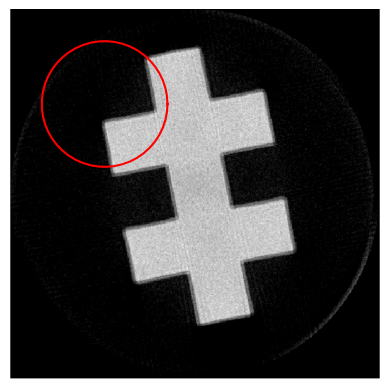

In [3]:
# define a circular snake (x + r cos(t), y + r sin(t)), where x_0 and y_0 are the center of the circle, r is the radius, and t is the angle parameter

def circle_snake(x_0, y_0, r, n):
    """
    Generate points along a circular snake.
    
    Parameters:
    -----------
    x_0, y_0 : float
        Coordinates of the circle center
    r : float
        Radius of the circle
    n : int
        Number of points along the circle
        
    Returns:
    --------
    snake : ndarray
        Array of shape (n, 2) containing the (x, y) coordinates of snake points
    """
    t = np.linspace(0, 2*np.pi, n)
    x = x_0 + r * np.cos(t)
    y = y_0 + r * np.sin(t)
    return np.array([x, y]).T

# define the snake parameters
n = 50
r = 100
x_0 = 150.
y_0 = 150.

# create the snake
snake = circle_snake(x_0, y_0, r, n)

# visualize the snake
plt.figure()
plt.imshow(D, cmap='gray')
plt.plot(snake[:, 0], snake[:, 1], 'r-')
plt.axis('off')
plt.show()






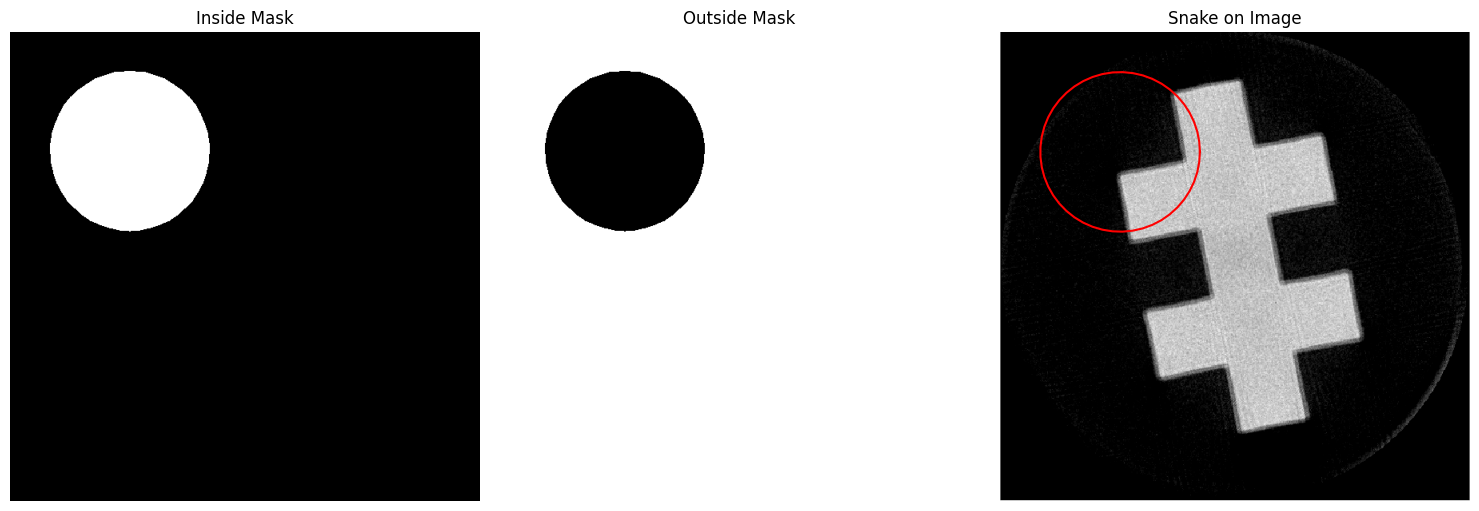

In [4]:
def create_snake_masks(image, snake):
    """
    Create inside and outside masks based on the snake contour.
    
    Parameters:
    -----------
    image : ndarray
        Input image
    snake : ndarray
        Array of shape (n, 2) containing the (x, y) coordinates of snake points
        
    Returns:
    --------
    mask_inside : ndarray
        Binary mask for the inside of the snake
    mask_outside : ndarray
        Binary mask for the outside of the snake
    """
    # Convert to integer coordinates for polygon2mask
    snake_int = snake.astype(int)
    
    # Create the inside mask
    mask_inside = polygon2mask(image.shape, snake_int).astype(float)
    
    # Create the outside mask (inverted inside mask)
    mask_outside = 1 - mask_inside
    
    return mask_inside, mask_outside


mask_inside, mask_outside = create_snake_masks(D, snake)

# visualize the masks and snake

visualize_masks_and_snake(D, snake, mask_inside, mask_outside)





In [5]:
def compute_mean_intensities(image, mask_inside, mask_outside):
    """
    Compute mean intensities inside and outside the snake.
    
    Parameters:
    -----------
    image : ndarray
        Input image
    mask_inside : ndarray
        Binary mask for the inside of the snake
    mask_outside : ndarray
        Binary mask for the outside of the snake
        
    Returns:
    --------
    mean_inside : float
        Mean intensity inside the snake
    mean_outside : float
        Mean intensity outside the snake
    """

    ####### INSIDE ########

    # Calculate mean inside by masking the image and computing mean of non-zero elements 
    # We multiply the image by the mask to only get pixels inside the snake

    inside_pixels = image * mask_inside
    
    # count only the pixels that are part of the mask (non-zero)
    n_pixels_inside = mask_inside.sum()
    # compute the mean (sum of all pixels divided by count)
    mean_inside = inside_pixels.sum() / n_pixels_inside if n_pixels_inside > 0 else 0

    ####### OTUSIDE ########
    outside_pixels = image * mask_outside
    n_pixels_outside = mask_outside.sum()
    mean_outside = outside_pixels.sum() / n_pixels_outside if n_pixels_outside > 0 else 0

    return mean_inside, mean_outside

In [6]:
# After creating masks inside and outside, we can compute the mean intensities inside and outside the snake
mean_inside, mean_outside = compute_mean_intensities(D, mask_inside, mask_outside)
print(f"Mean intensity inside the snake: {mean_inside:.4f}")
print(f"Mean intensity outside the snake: {mean_outside:.4f}")

Mean intensity inside the snake: 0.1895
Mean intensity outside the snake: 0.1640


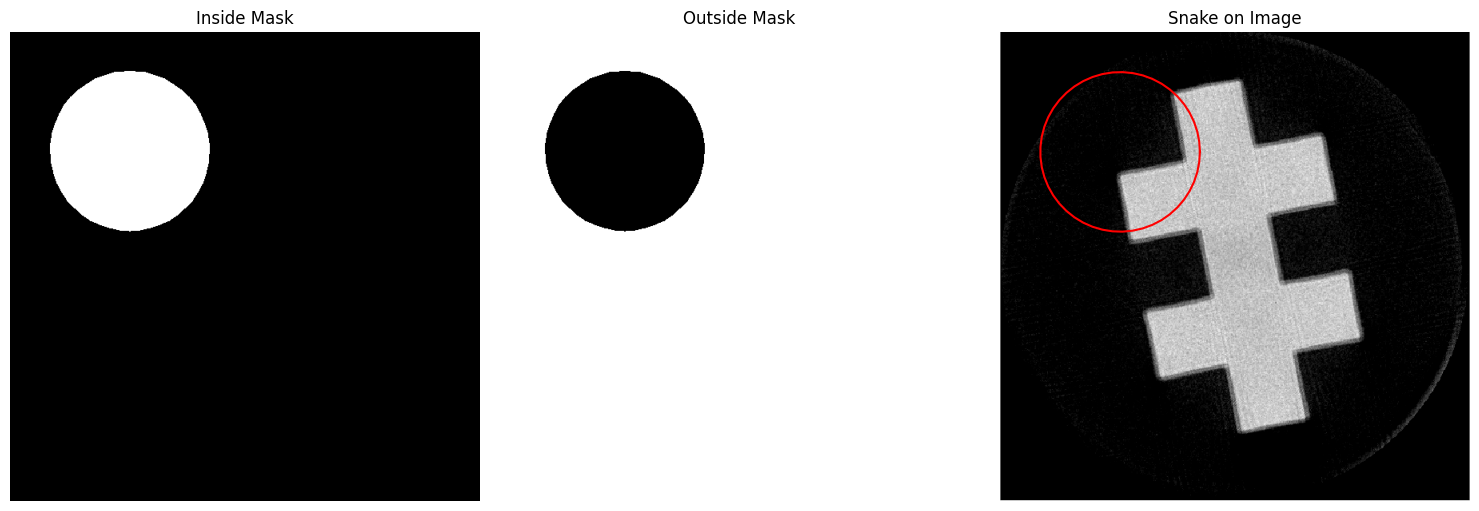

In [7]:
mask_inside, mask_outside = create_snake_masks(D, snake)

# visualize the masks and snake

visualize_masks_and_snake(D, snake, mask_inside, mask_outside)

In [8]:
# After creating masks inside and outside, we can compute the mean intensities inside and outside the snake
mean_inside, mean_outside = compute_mean_intensities(D, mask_inside, mask_outside)
print(f"Mean intensity inside the snake: {mean_inside:.4f}")
print(f"Mean intensity outside the snake: {mean_outside:.4f}")

print(D.shape)

Mean intensity inside the snake: 0.1895
Mean intensity outside the snake: 0.1640
(588, 588)


In [9]:
def calculate_normals(snake):
    normals = np.zeros((len(snake), 2))
        # calculate normal vector along the snake 
    #  For a closed curve, we use adjacent points to find the tangent,
    # then rotate 90 degrees to get the normal
    for i in range(n):
        # get previous and next points (with a wrap around closed curve)
        prev = (i - 1) % n
        next = (i + 1) % n

        # calculate tagent vector using central difference 
        tangent_x = snake[next, 0] - snake[prev, 0]
        tangent_y = snake[next, 1] - snake[prev, 1]

        # normalie the vectors 
        tangent_magnitude = np.sqrt(tangent_x**2 + tangent_y**2) + 1e-8
        tangent_x /= tangent_magnitude
        tangent_y /= tangent_magnitude

        # rotate 90 degrees to get the normal
        normals[i, 0] = -tangent_y
        normals[i, 1] = tangent_x

    return normals


def external_forces(snake, D, m_in, m_out, use_interpolation=False):
    n = len(snake)
    f_ext = np.zeros((n, 2))
    #print(f_ext)
    f_ext_magnitude = np.zeros(n)

    # Get intensities at each snake point
    intensities = np.zeros(n)
    if use_interpolation:
        # Implement interpolation method (using scipy.interpolate.RegularGridInterpolator or map_coordinates)
        from scipy.ndimage import map_coordinates
        
        # Convert points to the format expected by map_coordinates
        coords = np.zeros((2, n))
        coords[0, :] = snake[:, 1]  # y coordinates
        coords[1, :] = snake[:, 0]  # x coordinates
        
        # Perform the interpolation (order=1 is linear interpolation)
        intensities = map_coordinates(D, coords, order=1, mode='nearest')
    else:
        # Simple approach (rounding) - your existing code
        for i in range(n):
            # Get integer coordinates for image lookup 
            x_i, y_i = int(round(snake[i, 0])), int(round(snake[i, 1]))
            
            # Ensure coordinates are within image bounds
            x_i = max(0, min(x_i, D.shape[1]-1))
            y_i = max(0, min(y_i, D.shape[0]-1))
            
            # Get local intensity
            intensities[i] = D[y_i, x_i]
    

    # calculate the force magnigude for each point using Chan-Vese energy function
    f_ext_magnitude = (m_in - m_out) * (2 * intensities - m_in - m_out)
    # Inside external_forces function, after calculating f_ext_magnitude
    print(f"Force magnitude range: {np.min(f_ext_magnitude):.2f} to {np.max(f_ext_magnitude):.2f}")
    print(f"Mean inside: {m_in:.2f}, Mean outside: {m_out:.2f}")


    normals = calculate_normals(snake)
    

        # combine force magnitudes with normal directions 
    for i in range(n):
        f_ext[i, 0] = f_ext_magnitude[i] * normals[i, 0]
        f_ext[i, 1] = f_ext_magnitude[i] * normals[i, 1]

#    # 5. Visualize the snake and forces (only once, outside the loop)
#    plt.figure(figsize=(10, 8))
#    plt.imshow(D, cmap='gray')
#    plt.plot(snake[:, 0], snake[:, 1], 'r-', linewidth=2)
#    
#    # Visualize the normal vectors
#    plt.quiver(snake[:, 0], snake[:, 1], 
#               normals[:, 0], normals[:, 1], 
#               color='g', scale=20, label='Normals')
#    
#    # Visualize the forces (which may point inward or outward)
#    plt.quiver(snake[:, 0], snake[:, 1], 
#               f_ext[:, 0], f_ext[:, 1], 
#               color='b', scale=50, label='Forces')
#    
#    plt.title('Snake with Normal Vectors and External Forces')
#    plt.legend()
#    plt.axis('off')
#    plt.show()
    
    return f_ext


    

In [10]:
f_ext = external_forces(snake, D, m_in=mean_inside, m_out=mean_outside, use_interpolation=True)   
normals = calculate_normals(snake)

Force magnitude range: -0.01 to 0.03
Mean inside: 0.19, Mean outside: 0.16


In [11]:
def compute_displacement(snake, image, mean_inside, mean_outside):
    """Compute displacement magnitudes using Eq. 6.1."""
    # Get normal vectors
    normals = calculate_normals(snake)
    
    # Get image values at snake points
    snake_values = interpolate_image_at_snake(image, snake)
    
    # Apply equation 6.1: F_ext = (m_in - m_out)(2I - m_in - m_out)
    displacements = (mean_inside - mean_outside) * (2*snake_values - mean_inside - mean_outside)
    
    return displacements, normals


def update_snake(snake, displacement, normals, tau=0.1):
    """
    Update snake positions based on displacement magnitudes, normals, and step size tau.

    Parameters:
    -----------
    snake : ndarray
        Current snake coordinates.
    displacement : ndarray
        Scalar displacement magnitudes computed from external forces.
    normals : ndarray
        Normal vectors at snake points.
    tau : float
        Step size for the update.

    Returns:
    --------
    updated_snake : ndarray
        New snake coordinates after update.
    """
    updated_snake = snake + tau * (displacement[:, np.newaxis] * normals)
    return updated_snake


In [12]:
def visualize_displacement(snake, normals, f_ext, D):
    # Try different step sizes
    tau_values = [0.1, 0.5, 1.0, 2.0]
    
    plt.figure(figsize=(15, 10))
    for i, tau in enumerate(tau_values):
        # Displace snake with this tau
        new_snake = snake + tau * f_ext
        

    # 5. Visualize the snake and forces (only once, outside the loop)
    plt.figure(figsize=(10, 8))
    plt.imshow(D, cmap='gray')
    plt.plot(snake[:, 0], snake[:, 1], 'r-', linewidth=2)
    
    # Visualize the normal vectors
    plt.quiver(snake[:, 0], snake[:, 1], 
               normals[:, 0], normals[:, 1], 
               color='g', scale=20, label='Normals')
    
    # Visualize the forces (which may point inward or outward)
    plt.quiver(snake[:, 0], snake[:, 1], 
               f_ext[:, 0], f_ext[:, 1], 
               color='b', scale=50, label='Forces')
    
    plt.title('Snake with Normal Vectors and External Forces')
    plt.legend()
    plt.axis('off')
    plt.show()


def interpolate_image_at_snake(image, snake):
    """Interpolate image values at snake points."""
    from scipy.ndimage import map_coordinates
    
    # Convert RGB to grayscale if needed
    if len(image.shape) == 3:
        # Simple conversion: take mean of the RGB channels
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
    
    # Prepare coordinates (y,x order for map_coordinates)
    coords = np.vstack((snake[:, 1], snake[:, 0]))
    
    # Get interpolated values
    values = map_coordinates(image_gray, coords, order=1)
    
    return values

<Figure size 1500x1000 with 0 Axes>

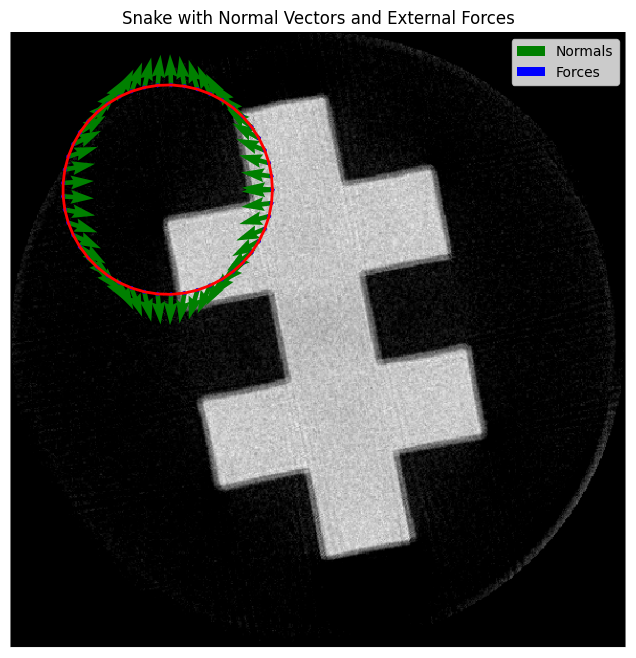

In [13]:
visualize_displacement(snake, normals, f_ext, D)

In [14]:
def evolve_snake(initial_snake, image, iterations, tau=1, use_interpolation=False, visualize_steps=False):
    """
    Evolve a snake curve over multiple iterations using the Chan-Vese model.
    
    Parameters:
    -----------
    initial_snake : ndarray
        Initial snake contour points, shape (n, 2)
    image : ndarray
        Input image (grayscale)
    iterations : int
        Number of iterations to evolve the snake
    tau : float
        Step size for displacement
    use_interpolation : bool
        Whether to use interpolation for intensity sampling
    visualize_steps : bool
        Whether to visualize the evolution process
        
    Returns:
    --------
    snake : ndarray
        Final snake position after evolution
    snake_history : list
        List of snake positions at each iteration (if visualize_steps=True)
    """
    # Initialize with the provided snake
    snake = initial_snake.copy()
    
    # Store snake evolution history if visualization is requested
    snake_history = []
    if visualize_steps:
        snake_history.append(snake.copy())
    
    # Evolve the snake for the specified number of iterations
    for i in range(iterations):
        # 1. Create masks for inside and outside regions
        mask_inside, mask_outside = create_snake_masks(image, snake)
        
        # 2. Compute mean intensities inside and outside
        mean_inside, mean_outside = compute_mean_intensities(image, mask_inside, mask_outside)
        
        # 3. Calculate external forces
        f_ext = external_forces(snake, image, mean_inside, mean_outside, use_interpolation)
        
        # 4. Apply displacement (implementation of part inside parentheses in equation 6.3)
        # Note: This doesn't yet include internal force regularization
        normals = calculate_normals(snake)

        new_snake = snake + tau * f_ext * normals
        
        # 5. Update snake for next iteration
        snake = new_snake.copy()
        
        # 6. Store this iteration's snake if tracking history
        if visualize_steps:
            snake_history.append(snake.copy())
            
        # Optional: Print progress
        #if (i+1) % 10 == 0:
        #    print(f"Completed iteration {i+1}/{iterations}")
    
    # Return the final snake and optionally the history
    if visualize_steps:
        return snake, snake_history
    else:
        return snake

def visualize_evolution_interactive(image, snake_history, pause_time=0):
    """
    Visualize the snake evolution interactively.
    
    Parameters:
    -----------
    image : ndarray
        Input image
    snake_history : list
        List of snake positions at each iteration
    pause_time : float
        Time to pause between frames (seconds)
    """
    from IPython.display import display, clear_output
    import time
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for i, snake in enumerate(snake_history):
        ax.clear()  # Clear previous frame
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Display the current snake
        ax.plot(snake[:, 0], snake[:, 1], 'c.-', linewidth=2)
        
        # Highlight the first and last points of the snake
        ax.plot(snake[0, 0], snake[0, 1], 'oc', ms=15)
        ax.plot(snake[-1, 0], snake[-1, 1], 'dc', ms=15)
        
        # Add title with iteration number
        ax.set_title(f'Snake Evolution - Iteration {i}')
        ax.axis('off')
        
        # Display the figure and clear output
        display(fig)
        clear_output(wait=True)
        
        # Pause to create animation effect
        time.sleep(pause_time)
    
    # Final frame (stays visible)
    ax.clear()
    ax.imshow(image, cmap='gray')
    ax.plot(snake_history[-1][:, 0], snake_history[-1][:, 1], 'g.-', linewidth=2)
    ax.plot(snake_history[-1][0, 0], snake_history[-1][0, 1], 'og', ms=15)
    ax.plot(snake_history[-1][-1, 0], snake_history[-1][-1, 1], 'dg', ms=15)
    ax.set_title(f'Final Snake After {len(snake_history)-1} Iterations')
    ax.axis('off')
    display(fig)
    plt.close()

# Example usage:
# initial_snake = circle_snake(300, 300, 100, 100)  # 100 points
# final_snake, history = evolve_snake(initial_snake, D, iterations=50, tau=0.5, visualize_steps=True)
# visualize_evolution(D, history, interval=5)

KeyboardInterrupt: 

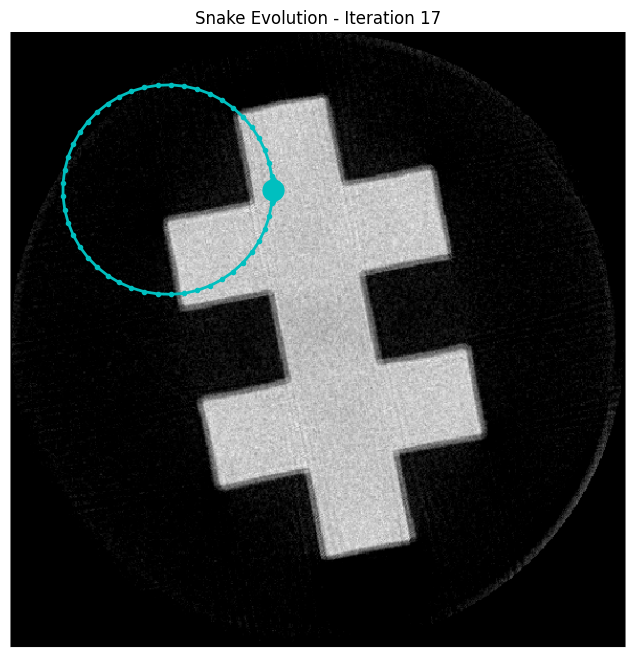

In [15]:
#initial_snake = circle_snake(300, 300, 100, 100)  # 100 points
final_snake, history = evolve_snake(snake, D, iterations=100, tau=0.5, visualize_steps=True)
visualize_evolution_interactive(D, history)

### Displacement equation 
$$F_{ext} = (m_{in}- m_{out}) (2I - m_{in} - m_{out})$$

- mᵢₙ is the mean intensity inside the snake
- mₒᵤₜ is the mean intensity outside the snake
- I is the image intensity at the snake point
- N is the normal vector at the snake point



#### Calculate normal vectors 
- For each snake point, compute the tangent vector using neighboring points
- Rotate the tangent vector by 90° to get the normal vector
- Normalize the normal vector to have unit length

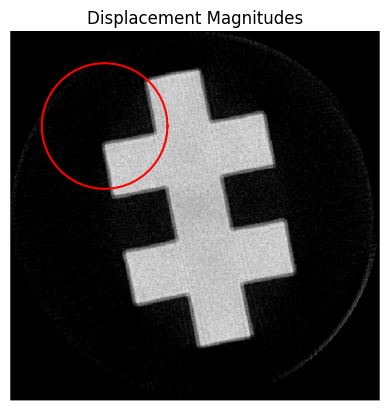

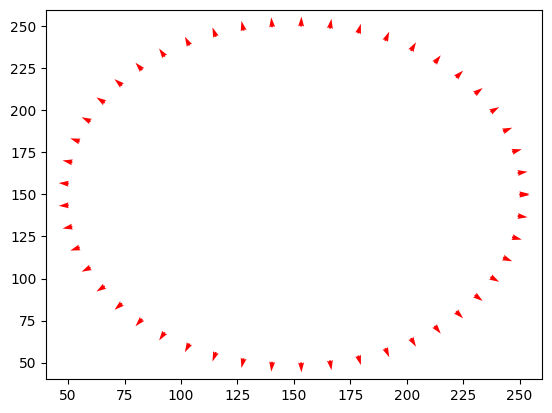

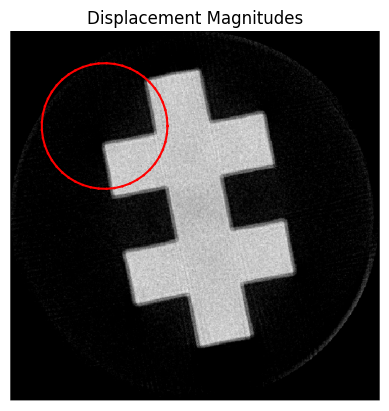

In [24]:
def get_neighbour_indices(i, n_points):
    normals = np.zeros((n_points, 2))

    prev_index = (i - 1) % n_points
    next_index = (i + 1) % n_points

    return prev_index, next_index

def calculate_tangent(snake, prev_idx, next_idx):
    """Calculate tangent vector using central difference."""
    tangent = snake[next_idx] - snake[prev_idx]
    return tangent


def calculate_normal(tangent):
    """Calculate outward normal vector by rotating tangent -90°."""
    normal = np.array([tangent[1], -tangent[0]])  # Reverse rotation
    magnitude = np.linalg.norm(normal)
    if magnitude > 0:
        normal /= magnitude
    return normal


def compute_snake_normals(snake):
    """Compute normal vectors for all snake points."""
    n_points = len(snake)
    normals = np.zeros_like(snake)
    
    for i in range(n_points):
        # Get neighbor indices
        prev_idx, next_idx = get_neighbour_indices(i, n_points)
        
        # Calculate tangent vector
        tangent = calculate_tangent(snake, prev_idx, next_idx)
        
        # Calculate normal vector
        normal = calculate_normal(tangent)
        
        # Store the normal
        normals[i] = normal
        
    return normals



def interpolate_image_at_snake(image, snake):
    """Interpolate image values at snake points."""
    from scipy.ndimage import map_coordinates
    
    # Convert RGB to grayscale if needed
    if len(image.shape) == 3:
        # Simple conversion: take mean of the RGB channels
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
    
    # Prepare coordinates (y,x order for map_coordinates)
    coords = np.vstack((snake[:, 1], snake[:, 0]))
    
    # Get interpolated values
    values = map_coordinates(image_gray, coords, order=1)
    
    return values

def compute_displacement(snake, image, mean_inside, mean_outside):
    """Compute displacement magnitudes using Eq. 6.1."""
    # Get normal vectors
    normals = compute_snake_normals(snake)
    
    # Get image values at snake points
    snake_values = interpolate_image_at_snake(image, snake)
    
    # Apply equation 6.1: F_ext = (m_in - m_out)(2I - m_in - m_out)
    displacements = (mean_inside - mean_outside) * (2*snake_values - mean_inside - mean_outside)
    
    return displacements, normals


displacement, normals = compute_displacement(snake, D, mean_inside, mean_outside)

# Visualize the displacement magnitudes
visualize_snake_on_image(D, snake, 'Displacement Magnitudes')
plt.quiver(snake[:, 0], snake[:, 1], normals[:, 0], normals[:, 1], color='r', scale=50)
plt.show()



# visualize displacement

def visualize_displacement(image, snake, displacement, title=None):
    """Visualize displacement magnitudes on an image."""
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.plot(snake[:, 0], snake[:, 1], 'r-')
    plt.quiver(snake[:, 0], snake[:, 1], displacement*normals[:, 0], displacement*normals[:, 1], color='r', scale=50)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

visualize_displacement(D, snake, displacement, 'Displacement Magnitudes')


In [25]:
def update_snake(snake, displacement, normals, tau=0.1):
    """
    Update snake positions based on displacement magnitudes, normals, and step size tau.

    Parameters:
    -----------
    snake : ndarray
        Current snake coordinates.
    displacement : ndarray
        Scalar displacement magnitudes computed from external forces.
    normals : ndarray
        Normal vectors at snake points.
    tau : float
        Step size for the update.

    Returns:
    --------
    updated_snake : ndarray
        New snake coordinates after update.
    """
    updated_snake = snake + tau * (displacement[:, np.newaxis] * normals)
    return updated_snake


KeyboardInterrupt: 

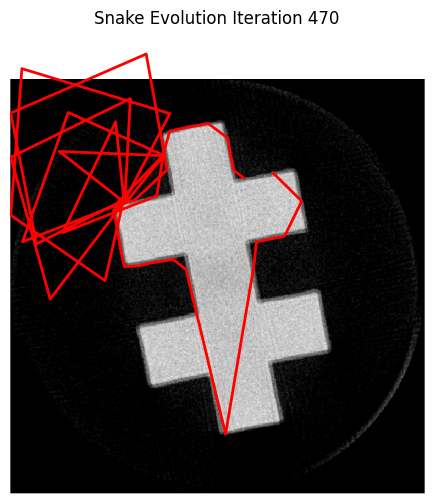

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

iterations = 500
tau = 10
alpha, beta = 1.1, 1.1  # for later use in regularization

snake_evolved = snake.copy()

fig, ax = plt.subplots(figsize=(6,6))

for iteration in range(iterations):
    # Compute masks
    mask_inside, mask_outside = create_snake_masks(D, snake_evolved)

    # Mean intensities
    mean_inside, mean_outside = compute_mean_intensities(D, mask_inside, mask_outside)

    # Compute external forces and normals
    displacement, normals = compute_displacement(snake_evolved, D, mean_inside, mean_outside)

    # Update snake positions
    snake_evolved = update_snake(snake_evolved, displacement, normals, tau)

    # Clear previous plot and visualize
    ax.clear()
    ax.imshow(D, cmap='gray')
    ax.plot(snake_evolved[:, 0], snake_evolved[:, 1], 'r-', lw=2)
    ax.set_title(f'Snake Evolution Iteration {iteration + 1}')
    ax.axis('off')
    
    display(fig)
    clear_output(wait=True)

plt.close()

